Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


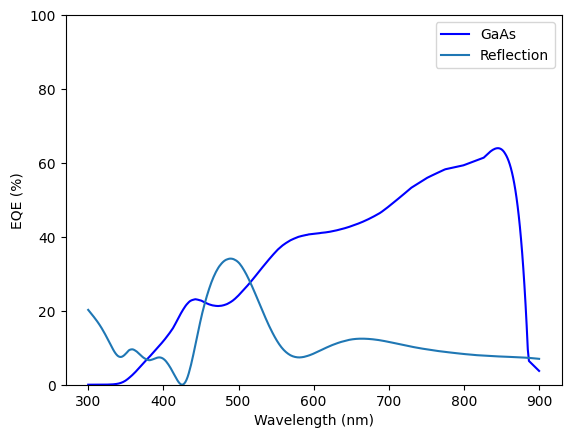

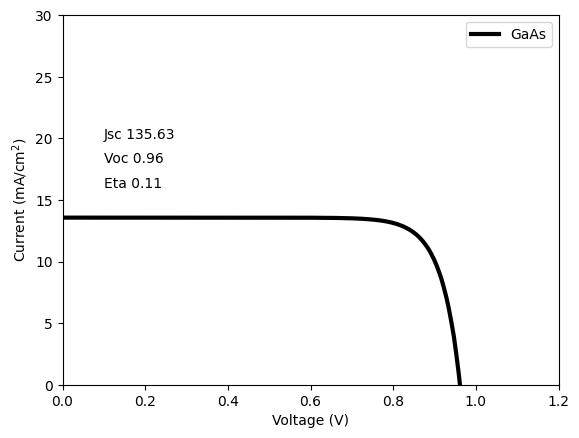

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from solcore import siUnits, material, si
from solcore.solar_cell import SolarCell
from solcore.structure import Junction, Layer
from solcore.solar_cell_solver import solar_cell_solver
from pathlib import Path
from solcore.light_source import LightSource


def this_dir_file(f):
    file_path = Path.cwd()
    return file_path / "data" /  f

# Define the materials we will use
MgF2 = material("MgF2")()
ZnS = material("ZnScub")()
AlInP = material("AlInP")
window_material = AlInP(Al=0.52)
GaAs = material("GaAs")

gaas_n_material = GaAs(Nd=siUnits(3e18, "cm-3"),
                       hole_diffusion_length=si("500nm"),
                       hole_mobility = 5e-2,
                       electron_mobility = 3.4e-3,
                       relative_permittivity = 9)
gaas_p_material = GaAs(Na=siUnits(1e17, "cm-3"), electron_diffusion_length=si("5um"),
                       hole_mobility = 3.4e-3,
                       electron_mobility = 5e-2,
                       relative_permittivity = 9)

# due to the metallisation of the cell = 2%, and indicate it has an area of 1x1 mm2 (converted to m2)
solar_cell = SolarCell(
    [Layer(si("200nm"), MgF2), Layer(si("200nm"), ZnS),
        Junction([Layer(si("55nm"), material=window_material, role='window'),
                    Layer(si("800nm"), material=gaas_n_material, role='emitter'),
                  Layer(si("3000nm"), material=gaas_p_material, role='base'),
                  ], sn=1, sp=1, kind='DA')
    ], shading=0.02, cell_area=1 / 1e4)

wl = np.linspace(300, 900, 400) * 1e-9
solar_cell_solver(solar_cell, 'qe', user_options={'wavelength': wl,
                                                  'optics_method': 'TMM'})
plt.figure(1)
plt.plot(wl * 1e9, solar_cell[2].eqe(wl) * 100, 'b', label='GaAs')
plt.plot(wl * 1e9, solar_cell.reflected*100, label='Reflection')
plt.legend()
plt.ylim(0, 100)
plt.ylabel('EQE (%)')
plt.xlabel('Wavelength (nm)')

am15spectrum=LightSource(source_type='standard',version='AM1.5g',x=wl,output_units='photon_flux_per_m')
V = np.linspace(0, 1.2, 200)
solar_cell_solver(solar_cell, 'iv', user_options={'voltages': V, 'light_iv': True, 'wavelength': wl, 'optics_method': 'TMM','light_source':am15spectrum,'mpp':True})

plt.figure(2)
plt.plot(V, solar_cell.iv['IV'][1]/10, 'k', linewidth=3, label='GaAs')
#plt.plot(V, -solar_cell[2].iv(V), 'b', label='GaAs')

plt.legend()
plt.ylim(0, 30)
plt.xlim(0, 1.2)
plt.ylabel('Current (mA/cm$^2$)')
plt.xlabel('Voltage (V)')
plt.text(0.1,20,f'Jsc {solar_cell.iv.Isc:.2f}')
plt.text(0.1,18,f'Voc {solar_cell.iv.Voc:.2f}')
plt.text(0.1,16,f'Eta {solar_cell.iv.Eta:.2f}')

plt.show()